In [4]:
import pandas as pd
import numpy as np
import math
import shap
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight
from astropy.coordinates import SkyCoord
import astropy.units as u
from xgboost import XGBClassifier
from grb_ml_utils import *

In [5]:
grbgen, big_table = load_big_greiner()

Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.


In [6]:
columns_to_use = ['T90','z','D_L',
                   'F_g', 'HR', 'E_iso', 'L_pk', 'F_pk1', 'F_pk2',
                   'P_pk1','P_pk4', 'alpha_band', 'beta_band', 'E_P_band',
                   'alpha_cpl', 'E_P_cpl', 'alpha_spl','spectral_lag',
                   'theta_j', 'Gamma0', 'log_t_burst',
                   't_b',
                   'F_X11hr', 'beta_X11hr', 'F_Opt11hr',
                   'T_ai', 'L_a',
                   'offset', 'metallicity',
                   'A_V', 'SFR',
                   'SSFR', 'Age', 'Mass']

rows_to_use = np.zeros(len(big_table),dtype=bool)
for feature in columns_to_use:
    if feature=='T90':
        continue
    else:
        rows_to_use = np.logical_or(rows_to_use,big_table[feature].notnull())
rows_to_use = np.logical_and(rows_to_use,big_table['T90'].notnull())
big_table = big_table[rows_to_use]

In [7]:
print(np.sum(big_table['class']==-1))
print(np.sum(big_table['class']!=-1))

3153
1367


[[9.9837434e-01 1.6256410e-03]
 [9.9991518e-01 8.4800769e-05]
 [9.9975693e-01 2.4306640e-04]
 ...
 [9.6310139e-01 3.6898635e-02]
 [9.9955595e-01 4.4405853e-04]
 [9.9990070e-01 9.9290490e-05]]


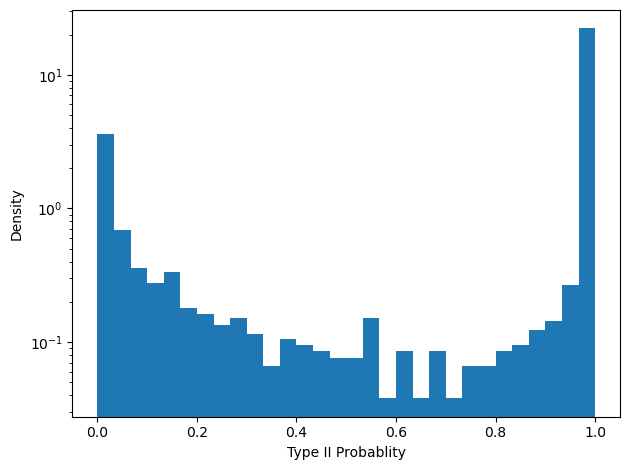

In [9]:
data_pd = big_table[big_table['class']!=-1]
X = data_pd[columns_to_use]
y = data_pd['class'].to_numpy()
test_X = big_table[big_table['class']==-1][columns_to_use]

clf = XGBClassifier(use_label_encoder=False,eval_metric='logloss')
sample_weight = compute_sample_weight('balanced',y=y)
clf.fit(X, y,sample_weight=sample_weight)
predictions = clf.predict(test_X)
prediction_proba = clf.predict_proba(test_X)
print(prediction_proba)
plt.hist(prediction_proba[:,0],30,density=True)
plt.yscale('log')
plt.ylabel('Density')
plt.xlabel('Type II Probablity')
plt.tight_layout()
plt.savefig('./paper/predict_proba.pdf')

In [11]:
# Number of predicted Type II and I GRBs
print(np.sum(np.argmax(prediction_proba,axis=1)==0))
print(np.sum(np.argmax(prediction_proba,axis=1)==1))

2474
679
